### Amazon Food Reviews - Support Vector Machines

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from scipy.sparse import find
from scipy.sparse import csr_matrix
from prettytable import PrettyTable
from scipy.stats import randint as sp_randint
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [6]:
svm_data = load_data('../Amazon_Food_Review_KNN/150k_nb')
svm_data_1 = svm_data.head(100000)
svm_data_2 = svm_data.head(25000)

In [7]:
def confusion_matrix_plot(y_test,pred):
    df_bow = pd.DataFrame(confusion_matrix(y_test, pred))  
    sns.heatmap(df_bow, annot=True)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    print('True Positive',tp)
    print('True Negative',tn)
    print('False Positive',fp)
    print('False Negative',fn)

In [8]:
def metric_scores(y_test,pred):
    acc_scores = [[accuracy_score(y_test, pred)*100,precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)]]
    acc_scores = pd.DataFrame(acc_scores,columns=['Accuracy','Precision score','Recall score','F1 score'])
    return acc_scores

In [9]:
def top_25_features(svm_optimal,vectorizer):
    
    zipped = zip(svm_optimal.coef_[0],vectorizer.get_feature_names())
    sorted_values = sorted(zipped, key=lambda x: x[0])
     
    pos_words = []
    neg_words = []
    for i in range(25):
        pos_words.append(sorted_values[len(sorted_values)-26+i][1])
        neg_words.append(sorted_values[i][1])

    pos_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",height=400 ,width=700).generate(" ".join(pos_words))
    plt.imshow(pos_wordcloud, interpolation='bilinear')
    plt.title('Positive Word Cloud')
    plt.axis("off")
    plt.show()
    
    neg_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",height=400 ,width=700).generate(" ".join(neg_words))
    plt.imshow(neg_wordcloud, interpolation='bilinear')
    plt.title('Negative Word Cloud')
    plt.axis("off")
    plt.show()

### Bag Of Words - SVM

### Best Hyperparameter C and Gamma using GridSearchCV

In [88]:
x_train, x_test, y_train, y_test = train_test_split(svm_data_2['Cleaned_Text'] ,svm_data_2['Score'], test_size=0.3, shuffle = False)
x_test.head()

496524    tri find chocol syrup without corn syrup soy e...
511438    husband extrem picki carnivor eat product one ...
382213    stuff inde kick least one notch fine substitut...
308531    general mill introduc cinnamon toast crunch br...
134769    come read label one manufactur suggest use rem...
Name: Cleaned_Text, dtype: object

In [89]:
from sklearn.preprocessing import Normalizer
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = count_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [13]:
svc = SVC()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
gamma_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'C':C_list,'gamma':gamma_list}
grid_search = GridSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 62.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 85.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000], 'gamma': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [14]:
save_data(grid_search,'bow_grid_search_svm')

In [15]:
a1 = load_data('bow_grid_search_svm')

In [16]:
print('Best C and Gamma ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best C and Gamma  {'C': 10, 'gamma': 0.1}
Best Accuracy 92.078189%


In [17]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a1.best_params_.get('C'),gamma = a1.best_params_.get('gamma'))
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [18]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,92.6,0.933961,0.986145,0.959344


True Positive 6548
True Negative 397
False Positive 463
False Negative 92


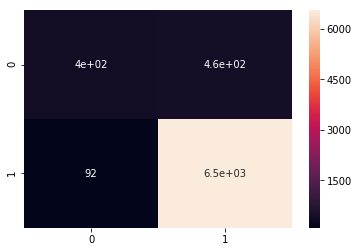

In [19]:
confusion_matrix_plot(y_test,pred)

### Best Hyperparameter C and Gamma using Randomized SearchCV

In [172]:
svc = SVC(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 3)
C_list =sp_randint(10**-3, 10**3)
gamma_list =sp_randint(10**-3, 10**3)
param_grid = {'C': C_list,'gamma': gamma_list}
grid_search = RandomizedSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_weighted'},refit= 'f1_weighted')
grid_search.fit(x_train,y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3d64ae48>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3d64a9b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1_weighted',
          return_train_score='warn', scoring={'f1_weighted'}, verbose=1)

In [173]:
save_data(grid_search,'bow_grid_search_svm_2')

In [174]:
a2 = load_data('bow_grid_search_svm_2')

In [175]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'C': 473, 'gamma': 3}
Best Accuracy 84.466832%


In [176]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a2.best_params_.get('C'),gamma = a2.best_params_.get('gamma'),class_weight = 'balanced')
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [177]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.72,0.887092,0.999849,0.940102


### SGD Classifier with Hinge Loss

In [179]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(svm_data_1['Cleaned_Text'] ,svm_data_1['Score'], test_size=0.3, shuffle = False)
x_test1.head()

103370    like tinkyada mrs leeper think textur par semo...
460141    also bought contain gold box offer everyon lov...
7199      wow organ lentil great lentil one planet top s...
401470    ive tri sever differ kind powder cappuccino mi...
359257    last case murray sugar free cooki chocol chip ...
Name: Cleaned_Text, dtype: object

In [180]:
from sklearn.preprocessing import Normalizer
count_vect1 = CountVectorizer()
x_train1 = count_vect1.fit_transform(x_train1)
normal_scale1 = Normalizer().fit(x_train1)
x_train1 = normal_scale1.transform(x_train1)
x_test1 = count_vect1.transform(x_test1)
x_test1 = normal_scale1.transform(x_test1)

In [181]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 5)
penalty_list = ['l1','l2','elasticnet']
alpha_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'penalty': penalty_list ,'alpha': alpha_list}
grid_search = GridSearchCV(sgd,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_weighted'},refit= 'f1_weighted')
grid_search.fit(x_train1,y_train1)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.4s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score='warn', scoring={'f1_weighted'}, verbose=1)

In [182]:
save_data(grid_search,'bow_grid_search_svm_sgd')

In [183]:
a2 = load_data('bow_grid_search_svm_sgd')

In [184]:
print('Best Alpha and Penalty ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best Alpha and Penalty  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy 87.333609%


In [185]:
from sklearn.metrics import accuracy_score
sgd_optimal = SGDClassifier(alpha = a2.best_params_.get('alpha'), penalty = a2.best_params_.get('penalty'),class_weight = 'balanced')
sgd_optimal.fit(x_train1, y_train1)
pred1 = sgd_optimal.predict(x_test1)
acc1 = accuracy_score(y_test1, pred1) * 100

In [186]:
metric_scores(y_test1,pred1)

,Accuracy,Precision score,Recall score,F1 score
0,85.7,0.978944,0.852697,0.91147


True Positive 22084
True Negative 3626
False Positive 475
False Negative 3815


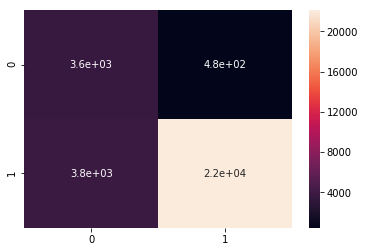

In [187]:
confusion_matrix_plot(y_test1,pred1)

### Top 25 Positive and Negative Features

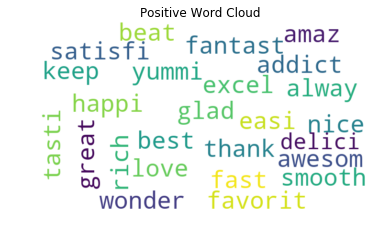

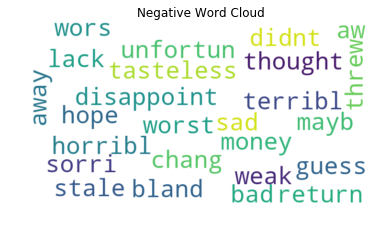

In [188]:
top_25_features(sgd_optimal,count_vect1)

### Trigrams - SVM

### Best Hyperparameter C and Gamma using GridSearchCV

In [11]:
x_train, x_test, y_train, y_test = train_test_split(svm_data_2['Cleaned_Text'] ,svm_data_2['Score'], test_size=0.3, shuffle = False)
x_test.head()

496524    tri find chocol syrup without corn syrup soy e...
511438    husband extrem picki carnivor eat product one ...
382213    stuff inde kick least one notch fine substitut...
308531    general mill introduc cinnamon toast crunch br...
134769    come read label one manufactur suggest use rem...
Name: Cleaned_Text, dtype: object

In [12]:
from sklearn.preprocessing import Normalizer
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train = ngram_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = ngram_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [29]:
svc = SVC()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
gamma_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'C':C_list,'gamma':gamma_list}
grid_search = GridSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 148.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 202.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000], 'gamma': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [30]:
save_data(grid_search,'trigram_grid_search_svm')

In [31]:
a1 = load_data('trigram_grid_search_svm')

In [32]:
print('Best C and Gamma ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best C and Gamma  {'C': 1000, 'gamma': 0.005}
Best Accuracy 92.071331%


In [33]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a1.best_params_.get('C'),gamma = a1.best_params_.get('gamma'))
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [34]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,92.64,0.93963,0.979819,0.959304


True Positive 6506
True Negative 442
False Positive 418
False Negative 134


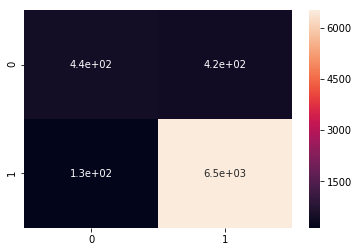

In [35]:
confusion_matrix_plot(y_test,pred)

### Best Hyperparameter C and Gamma using Randomized SearchCV

In [15]:
svc = SVC(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 3)
C_list =sp_randint(10**-3, 10**3)
gamma_list =sp_randint(10**-3, 10**3)
param_grid = {'C': C_list,'gamma': gamma_list}
grid_search = RandomizedSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_weighted'},refit= 'f1_weighted')
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 28.0min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3f3ebeb8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3f3ebef0>},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1_weighted',
          return_train_score='warn', scoring={'f1_weighted'}, verbose=1)

In [16]:
save_data(grid_search,'trigram_grid_search_svm_2')

In [17]:
a2 = load_data('trigram_grid_search_svm_2')

In [18]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'C': 239, 'gamma': 651}
Best Accuracy 84.319343%


In [19]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a2.best_params_.get('C'),gamma = a2.best_params_.get('gamma'),class_weight = 'balanced')
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [20]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.533333,0.885333,1.0,0.93918


### SGD Classifier with Hinge Loss

In [22]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(svm_data_1['Cleaned_Text'] ,svm_data_1['Score'], test_size=0.3, shuffle = False)
x_test1.head()

103370    like tinkyada mrs leeper think textur par semo...
460141    also bought contain gold box offer everyon lov...
7199      wow organ lentil great lentil one planet top s...
401470    ive tri sever differ kind powder cappuccino mi...
359257    last case murray sugar free cooki chocol chip ...
Name: Cleaned_Text, dtype: object

In [23]:
from sklearn.preprocessing import Normalizer
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train1 = ngram_vect.fit_transform(x_train1)
normal_scale1 = Normalizer().fit(x_train1)
x_train1 = normal_scale1.transform(x_train1)
x_test1 = ngram_vect.transform(x_test1)
x_test1 = normal_scale1.transform(x_test1)

In [31]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 5)
penalty_list = ['l1','l2','elasticnet']
alpha_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'penalty': penalty_list ,'alpha': alpha_list}
grid_search = GridSearchCV(sgd,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train1,y_train1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   43.7s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [32]:
save_data(grid_search,'trigram_grid_search_svm_sgd')

In [33]:
a2 = load_data('trigram_grid_search_svm_sgd')

In [34]:
print('Best Alpha and Penalty ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best Alpha and Penalty  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy 89.111949%


In [28]:
from sklearn.metrics import accuracy_score
sgd_optimal = SGDClassifier(alpha = a2.best_params_.get('alpha'), penalty = a2.best_params_.get('penalty'),class_weight = 'balanced')
sgd_optimal.fit(x_train1, y_train1)
pred1 = sgd_optimal.predict(x_test1)
acc1 = accuracy_score(y_test1, pred1) * 100

In [35]:
metric_scores(y_test1,pred1)

,Accuracy,Precision score,Recall score,F1 score
0,87.76,0.975322,0.880497,0.925487


True Positive 22804
True Negative 3524
False Positive 577
False Negative 3095


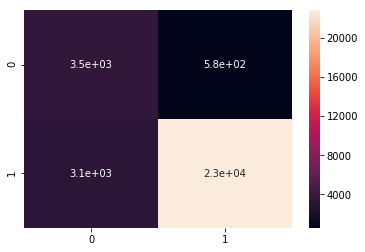

In [36]:
confusion_matrix_plot(y_test1,pred1)

### Top 25 Positive and Negative Features

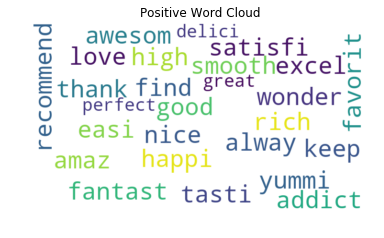

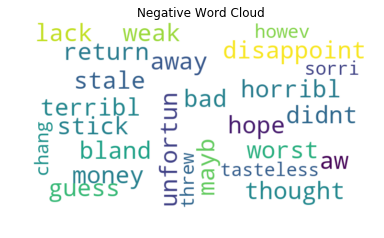

In [38]:
top_25_features(sgd_optimal,ngram_vect)

### Tf-Idf SVM

### Best Hyperparameter C and Gamma using GridSearchCV

In [39]:
x_train, x_test, y_train, y_test = train_test_split(svm_data_2['Cleaned_Text'] ,svm_data_2['Score'], test_size=0.3, shuffle = False)
x_test.head()

496524    tri find chocol syrup without corn syrup soy e...
511438    husband extrem picki carnivor eat product one ...
382213    stuff inde kick least one notch fine substitut...
308531    general mill introduc cinnamon toast crunch br...
134769    come read label one manufactur suggest use rem...
Name: Cleaned_Text, dtype: object

In [40]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = tf_idf_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [45]:
svc = SVC()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
gamma_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'C':C_list,'gamma':gamma_list}
grid_search = GridSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 124.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 165.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000], 'gamma': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [46]:
save_data(grid_search,'tfidf_grid_search_svm')

In [47]:
a1 = load_data('tfidf_grid_search_svm')

In [48]:
print('Best C and Gamma ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best C and Gamma  {'C': 500, 'gamma': 0.005}
Best Accuracy 91.673525%


In [49]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a1.best_params_.get('C'),gamma = a1.best_params_.get('gamma'))
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [50]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,92.68,0.935881,0.984789,0.959712


True Positive 6539
True Negative 412
False Positive 448
False Negative 101


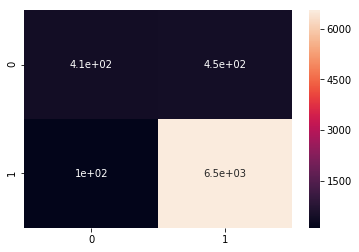

In [51]:
confusion_matrix_plot(y_test,pred)

### Best Hyperparameter C and Gamma using Randomized SearchCV

In [41]:
svc = SVC(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 3)
C_list =sp_randint(10**-3, 10**3)
gamma_list =sp_randint(10**-3, 10**3)
param_grid = {'C': C_list,'gamma': gamma_list}
grid_search = RandomizedSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_weighted'},refit= 'f1_weighted')
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.4min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a564bc7b8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a564bc9e8>},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1_weighted',
          return_train_score='warn', scoring={'f1_weighted'}, verbose=1)

In [42]:
save_data(grid_search,'tfidf_grid_search_svm_2')

In [43]:
a2 = load_data('tfidf_grid_search_svm_2')

In [44]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'C': 42, 'gamma': 174}
Best Accuracy 84.319343%


In [45]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a2.best_params_.get('C'),gamma = a2.best_params_.get('gamma'),class_weight = 'balanced')
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [46]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.533333,0.885333,1.0,0.93918


### SGD Classifier with Hinge Loss

In [48]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(svm_data_1['Cleaned_Text'] ,svm_data_1['Score'], test_size=0.3, shuffle = False)
x_test1.head()

103370    like tinkyada mrs leeper think textur par semo...
460141    also bought contain gold box offer everyon lov...
7199      wow organ lentil great lentil one planet top s...
401470    ive tri sever differ kind powder cappuccino mi...
359257    last case murray sugar free cooki chocol chip ...
Name: Cleaned_Text, dtype: object

In [49]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train1 = tf_idf_vect.fit_transform(x_train1)
normal_scale1 = Normalizer().fit(x_train1)
x_train1 = normal_scale1.transform(x_train1)
x_test1 = tf_idf_vect.transform(x_test1)
x_test1 = normal_scale1.transform(x_test1)

In [50]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 5)
penalty_list = ['l1','l2','elasticnet']
alpha_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'penalty': penalty_list ,'alpha': alpha_list}
grid_search = GridSearchCV(sgd,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train1,y_train1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   23.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [51]:
save_data(grid_search,'tfidf_grid_search_svm_sgd')

In [52]:
a2 = load_data('tfidf_grid_search_svm_sgd')

In [53]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy 90.790331%


In [54]:
from sklearn.metrics import accuracy_score
sgd_optimal = SGDClassifier(alpha = a2.best_params_.get('alpha'), penalty = a2.best_params_.get('penalty'),class_weight = 'balanced')
sgd_optimal.fit(x_train1, y_train1)
pred1 = sgd_optimal.predict(x_test1)
acc1 = accuracy_score(y_test1, pred1) * 100

In [55]:
metric_scores(y_test1,pred1)

,Accuracy,Precision score,Recall score,F1 score
0,88.813333,0.977383,0.891038,0.932216


True Positive 23077
True Negative 3567
False Positive 534
False Negative 2822


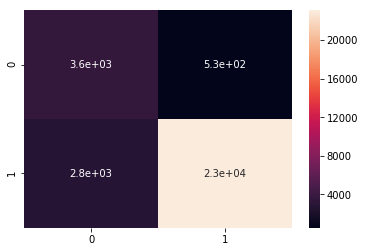

In [56]:
confusion_matrix_plot(y_test1,pred1)

### Top 25 Positive and Negative Features

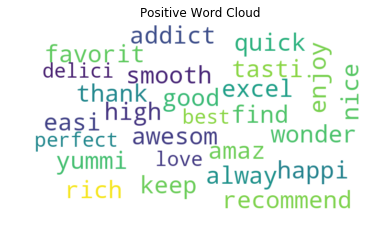

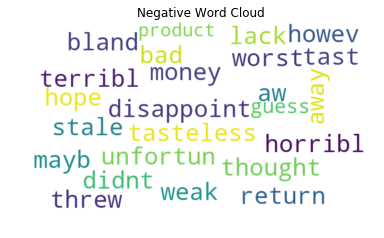

In [57]:
top_25_features(sgd_optimal,tf_idf_vect)

### Word2Vec - SVM

### Best Hyperparameter C and Gamma using GridSearchCV

In [58]:
x_train, x_test, y_train, y_test = train_test_split(svm_data_2['Cleaned_Text'] ,svm_data_2['Score'], test_size=0.3, shuffle = False)

In [59]:
list_of_train_sent = []
for sent in x_train.values:
    list_of_train_sent.append(sent.split())

In [60]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)
w2v_words = list(w2v_model.wv.vocab)

In [61]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [62]:
sent_vectors_arr = np.asarray(sent_vectors)
x_train = normalize(sent_vectors_arr)

In [63]:
list_of_test_sent = []
for sent in x_test.values:
    list_of_test_sent.append(sent.split())

In [64]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [65]:
sent_vectors_arr = np.asarray(sent_vectors)
x_test = normalize(sent_vectors_arr)

In [34]:
svc = SVC()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
gamma_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'C':C_list,'gamma':gamma_list}
grid_search = GridSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 35.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000], 'gamma': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [35]:
save_data(grid_search,'w2v_grid_search_svm')

In [36]:
a1 = load_data('w2v_grid_search_svm')

In [37]:
print('Best C and Gamma ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best C and Gamma  {'C': 1000, 'gamma': 0.1}
Best Accuracy 90.733882%


In [38]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a1.best_params_.get('C'),gamma = a1.best_params_.get('gamma'))
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [39]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,90.16,0.906138,0.991566,0.946929


True Positive 6584
True Negative 178
False Positive 682
False Negative 56


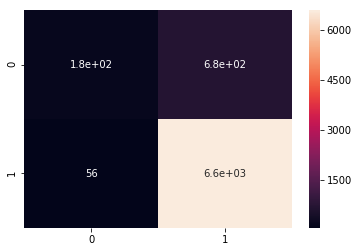

In [40]:
confusion_matrix_plot(y_test,pred)

### Best Hyperparameter C and Gamma using Randomized SearchCV

In [75]:
svc = SVC(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 3)
C_list =sp_randint(10**-3, 10**3)
gamma_list =sp_randint(10**-3, 10**3)
param_grid = {'C': C_list,'gamma': gamma_list}
grid_search = RandomizedSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a62fc6b70>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a62fc68d0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [76]:
save_data(grid_search,'w2v_grid_search_svm_2')

In [77]:
a2 = load_data('w2v_grid_search_svm_2')

In [78]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'C': 7, 'gamma': 392}
Best Accuracy 89.340952%


In [79]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a2.best_params_.get('C'),gamma = a2.best_params_.get('gamma'),class_weight = 'balanced')
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [80]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.533333,0.885333,1.0,0.93918


### SGD Classifier with Hinge Loss

In [82]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(svm_data_1['Cleaned_Text'] ,svm_data_1['Score'], test_size=0.3, shuffle = False)
x_test1.head()

103370    like tinkyada mrs leeper think textur par semo...
460141    also bought contain gold box offer everyon lov...
7199      wow organ lentil great lentil one planet top s...
401470    ive tri sever differ kind powder cappuccino mi...
359257    last case murray sugar free cooki chocol chip ...
Name: Cleaned_Text, dtype: object

In [83]:
list_of_train_sent = []
for sent in x_train1.values:
    list_of_train_sent.append(sent.split())

In [84]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)
w2v_words = list(w2v_model.wv.vocab)

In [85]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [86]:
sent_vectors_arr = np.asarray(sent_vectors)
x_train1 = normalize(sent_vectors_arr)

In [87]:
list_of_test_sent = []
for sent in x_test1.values:
    list_of_test_sent.append(sent.split())

In [88]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [89]:
sent_vectors_arr = np.asarray(sent_vectors)
x_test1 = normalize(sent_vectors_arr)

In [97]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 5)
penalty_list = ['l1','l2','elasticnet']
alpha_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'penalty': penalty_list ,'alpha': alpha_list}
grid_search = GridSearchCV(sgd,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'f1_weighted'},refit= 'f1_weighted')
grid_search.fit(x_train1,y_train1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit='f1_weighted',
       return_train_score='warn', scoring={'f1_weighted'}, verbose=1)

In [98]:
save_data(grid_search,'w2v_grid_search_svm_sgd')

In [99]:
a2 = load_data('w2v_grid_search_svm_sgd')

In [100]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'alpha': 0.001, 'penalty': 'elasticnet'}
Best Accuracy 85.435105%


In [101]:
from sklearn.metrics import accuracy_score
sgd_optimal = SGDClassifier(alpha = a2.best_params_.get('alpha'), penalty = a2.best_params_.get('penalty'),class_weight = 'balanced')
sgd_optimal.fit(x_train1, y_train1)
pred1 = sgd_optimal.predict(x_test1)
acc1 = accuracy_score(y_test1, pred1) * 100

In [102]:
metric_scores(y_test1,pred1)

,Accuracy,Precision score,Recall score,F1 score
0,80.853333,0.97208,0.801228,0.878424


True Positive 20751
True Negative 3505
False Positive 596
False Negative 5148


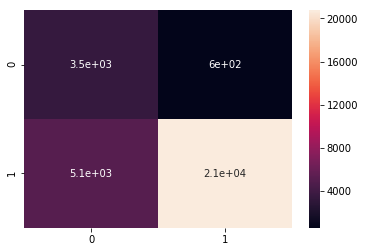

In [103]:
confusion_matrix_plot(y_test1,pred1)

### Tf-Idf Word2Vec SVM

In [104]:
x_train, x_test, y_train, y_test = train_test_split(svm_data_2['Cleaned_Text'],svm_data_2['Score'], test_size=0.3, random_state=0)

In [49]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)

In [50]:
dict_svm = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [52]:
from tqdm import tqdm

In [53]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_train_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #tf_idf = x_train[row, tfidf_feat.index(word)]
            tf_idf = dict_svm[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1
    #if row == (x_train.shape[0]):
        #break

100%|██████████| 17500/17500 [57:03<00:00,  7.14it/s]  


In [54]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_train = normalize(tfidf_sent_vectors_arr)
x_test = tf_idf_vect.transform(x_test)

In [55]:
save_data(x_train,'tfidf_w2v_train_set_svm')

In [105]:
x_train = load_data('tfidf_w2v_train_set_svm')

In [56]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_test_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #tf_idf = x_test[row, tfidf_feat.index(word)]
            tf_idf = dict_svm[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1
    #if row == (x_test.shape[0]):
        #break

100%|██████████| 7500/7500 [22:45<00:00,  5.49it/s]  


In [57]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_test = normalize(tfidf_sent_vectors_arr)

In [58]:
save_data(x_test,'tfidf_w2v_test_set_svm')

In [106]:
x_test = load_data('tfidf_w2v_test_set_svm')

### Best Hyperparameter C and Gamma using GridSearchCV

In [62]:
svc = SVC()
time_split_cv = TimeSeriesSplit(n_splits = 3)
C_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
gamma_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'C':C_list,'gamma':gamma_list}
grid_search = GridSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 47.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000], 'gamma': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [63]:
save_data(grid_search,'tfidf_w2v_grid_search_svm')

In [112]:
a1 = load_data('tfidf_w2v_grid_search_svm')

In [113]:
print('Best C and Gamma ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best C and Gamma  {'C': 0.0001, 'gamma': 0.0001}
Best Accuracy 88.827160%


In [66]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a1.best_params_.get('C'),gamma = a1.best_params_.get('gamma'))
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [67]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.906667,0.889067,1.0,0.941276


True Positive 6668
True Negative 0
False Positive 832
False Negative 0


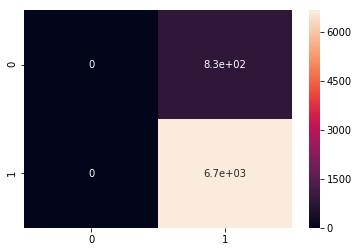

In [68]:
confusion_matrix_plot(y_test,pred)

### Best Hyperparameter C and Gamma using Randomized SearchCV

In [107]:
svc = SVC()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list =sp_randint(10**-3, 10**3)
gamma_list =sp_randint(10**-3, 10**3)
param_grid = {'C':C_list,'gamma':gamma_list}
grid_search = RandomizedSearchCV(svc,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.3min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a5f2b15f8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a5f2b1630>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [108]:
save_data(grid_search,'tfidf_w2v_grid_search_svm_2')

In [114]:
a2 = load_data('tfidf_w2v_grid_search_svm_2')

In [115]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'C': 513, 'gamma': 708}
Best Accuracy 88.806584%


In [116]:
from sklearn.metrics import accuracy_score
svc_optimal = SVC(C = a2.best_params_.get('C'),gamma = a2.best_params_.get('gamma'),class_weight = 'balanced')
svc_optimal.fit(x_train, y_train)
pred = svc_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [117]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.893333,0.889052,0.99985,0.941201


### SGD Classifier with Hinge Loss

In [149]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(class_weight = 'balanced')
time_split_cv = TimeSeriesSplit(n_splits = 5)
penalty_list = ['l1','l2','elasticnet']
alpha_list = [0.0001,0.005,0.001,0.01,0.1,1,10,100,500,1000]
param_grid = {'penalty': penalty_list ,'alpha': alpha_list}
grid_search = GridSearchCV(sgd,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1,scoring = {'precision_weighted'},refit= 'precision_weighted')
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit='precision_weighted',
       return_train_score='warn', scoring={'precision_weighted'},
       verbose=1)

In [150]:
save_data(grid_search,'tfidf_w2v_grid_search_svm_sgd')

In [151]:
a2 = load_data('tfidf_w2v_grid_search_svm_sgd')

In [152]:
print('Best C and Gamma ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best C and Gamma  {'alpha': 0.005, 'penalty': 'l2'}
Best Accuracy 80.777756%


In [153]:
from sklearn.metrics import accuracy_score
sgd_optimal = SGDClassifier(alpha = a2.best_params_.get('alpha'), penalty = a2.best_params_.get('penalty'),class_weight='balanced')
sgd_optimal.fit(x_train, y_train)
pred = sgd_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [154]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,73.053333,0.889261,0.796041,0.840073


True Positive 5308
True Negative 171
False Positive 661
False Negative 1360


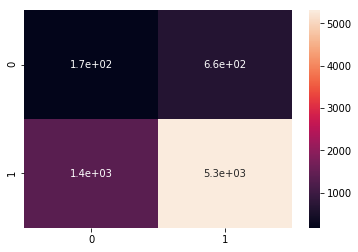

In [155]:
confusion_matrix_plot(y_test,pred)

### Summary


| Model | CV - Type | Best C | Best Gamma | Best Accuracy |
| --- | --- | --- | --- | ---|
|    BOW       |    Grid Search    |   10   |    0.1     | 92.07818930041152 |
|     BOW      | Randomized Search |  473   |     3      | 84.46683191240267 |
|   Trigram    |    Grid Search    |  1000  |   0.005    | 92.07133058984911 |
|   Trigram    | Randomized Search |  239   |    651     | 84.31934347794109 |
|    Tf-Idf    |    Grid Search    |  500   |   0.005    | 91.67352537722908 |
|    Tf-Idf    | Randomized Search |   42   |    174     | 84.31934347794109 |
|     W2V      |    Grid Search    |  1000  |    0.1     | 90.73388203017832 |
|     W2V      | Randomized Search |   7    |    392     | 89.34095238095237 |
| Tf-Idf - W2v |    Grid Search    | 0.0001 |   0.0001   | 88.82716049382717 |
| Tf-Idf - W2v | Randomized Search |  513   |    708     | 88.80658436213992 |